In [5]:
import pandas as pd

In [6]:
api="9b5fc2989397461a86821d398a7c70"

In [7]:
df=pd.read_csv('apple3.csv')

In [8]:
df

,Date,Close,High,Low,Open,Volume
0,NaN,AAPL,AAPL,AAPL,AAPL,AAPL
1,2023-05-24,170.13653564453125,170.71078788094945,168.82962874348078,169.39397044171028,45143500
2,2023-05-25,171.275146484375,172.1761141248664,169.98803043113716,170.70089424192957,56058300
3,2023-05-26,173.69094848632812,174.0275895351184,171.39395459047836,171.60187949980389,54835000
4,2023-05-30,175.5424346923828,177.21568420222022,174.81967538543662,175.20580872558915,55964400
...,...,...,...,...,...,...
498,2025-05-19,208.77999877929688,209.47999572753906,204.25999450683594,207.91000366210938,46140500
499,2025-05-20,206.86000061035156,208.47000122070312,205.02999877929688,207.6699981689453,42496600
500,2025-05-21,202.08999633789062,207.0399932861328,200.7100067138672,205.1699981689453,59211800
501,2025-05-22,201.36000061035156,202.75,199.6999969482422,200.7100067138672,46742400


In [9]:
df=df.iloc[1:]

In [10]:
df=df[['Date', 'Close']]

In [11]:
df['Date'] = pd.to_datetime(df['Date'])


In [13]:
from newsapi import NewsApiClient
from transformers import pipeline
import time

In [14]:
newsapi = NewsApiClient(api_key='9b5fc298939746186821398a7c70')
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Function to get average sentiment for a given date
def get_sentiment_score_for_date(date):
    try:
        articles = newsapi.get_everything(
            q='Apple Inc',
            from_param=date,
            to=date,
            sort_by='relevancy',
            language='en',
            page_size=20
        )
        scores = []
        for article in articles['articles']:
            try:
                result = sentiment_model(article['title'])[0]['label']
                if result == 'LABEL_2':
                    scores.append(5)
                elif result == 'LABEL_1':
                    scores.append(2)
                else:
                    scores.append(1)
            except:
                continue
        return sum(scores)/len(scores) if scores else 2  # default to neutral
    except:
        return 2

# Process only dates in your stock data
sentiment_scores = []
for date in df['Date']:
    date_str = date.strftime('%Y-%m-%d')
    print(f"Processing sentiment for: {date_str}")
    score = get_sentiment_score_for_date(date_str)
    sentiment_scores.append(score)
    time.sleep(1)  # avoid rate limit

# Add scores to your original dataframe
df['Sentiment Score'] = sentiment_scores
print(df.head())


Device set to use cpu


Processing sentiment for: 2023-05-24
Processing sentiment for: 2023-05-25
Processing sentiment for: 2023-05-26
Processing sentiment for: 2023-05-30
Processing sentiment for: 2023-05-31
Processing sentiment for: 2023-06-01
Processing sentiment for: 2023-06-02
Processing sentiment for: 2023-06-05
Processing sentiment for: 2023-06-06
Processing sentiment for: 2023-06-07
Processing sentiment for: 2023-06-08
Processing sentiment for: 2023-06-09
Processing sentiment for: 2023-06-12
Processing sentiment for: 2023-06-13
Processing sentiment for: 2023-06-14
Processing sentiment for: 2023-06-15
Processing sentiment for: 2023-06-16
Processing sentiment for: 2023-06-20
Processing sentiment for: 2023-06-21
Processing sentiment for: 2023-06-22
Processing sentiment for: 2023-06-23
Processing sentiment for: 2023-06-26
Processing sentiment for: 2023-06-27
Processing sentiment for: 2023-06-28
Processing sentiment for: 2023-06-29
Processing sentiment for: 2023-06-30
Processing sentiment for: 2023-07-03
P

In [15]:
df

,Date,Close,Sentiment Score
1,2023-05-24,170.13653564453125,2
2,2023-05-25,171.275146484375,2
3,2023-05-26,173.69094848632812,2
4,2023-05-30,175.5424346923828,2
5,2023-05-31,175.492919921875,2
...,...,...,...
498,2025-05-19,208.77999877929688,2
499,2025-05-20,206.86000061035156,2
500,2025-05-21,202.08999633789062,2
501,2025-05-22,201.36000061035156,2


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt



# Select features
data = df[['Close', 'Sentiment Score']]

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # Predicting Close Price
    return np.array(X), np.array(y)

sequence_length = 60  # Use past 60 days
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [19]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


C:\Users\nanir\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - loss: 0.1989 - val_loss: 0.0447
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0200 - val_loss: 0.0254
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0105 - val_loss: 0.0153
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0088 - val_loss: 0.0178
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0071 - val_loss: 0.0140
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0054 - val_loss: 0.0156
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0050 - val_loss: 0.0159
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0046 - val_loss: 0.0152
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0043 - val_loss: 0.0154
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0039 - val_loss: 0.0151
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0043 - val_loss: 0.0149
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.

In [20]:
# Predict
predictions = model.predict(X_test)

# Inverse scale to original prices
predicted_prices = scaler.inverse_transform(np.concatenate([predictions, X_test[:, -1, 1].reshape(-1,1)], axis=1))[:, 0]
actual_prices = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), X_test[:, -1, 1].reshape(-1,1)], axis=1))[:, 0]

# Create date range for test
test_dates = df.index[sequence_length + split:]


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


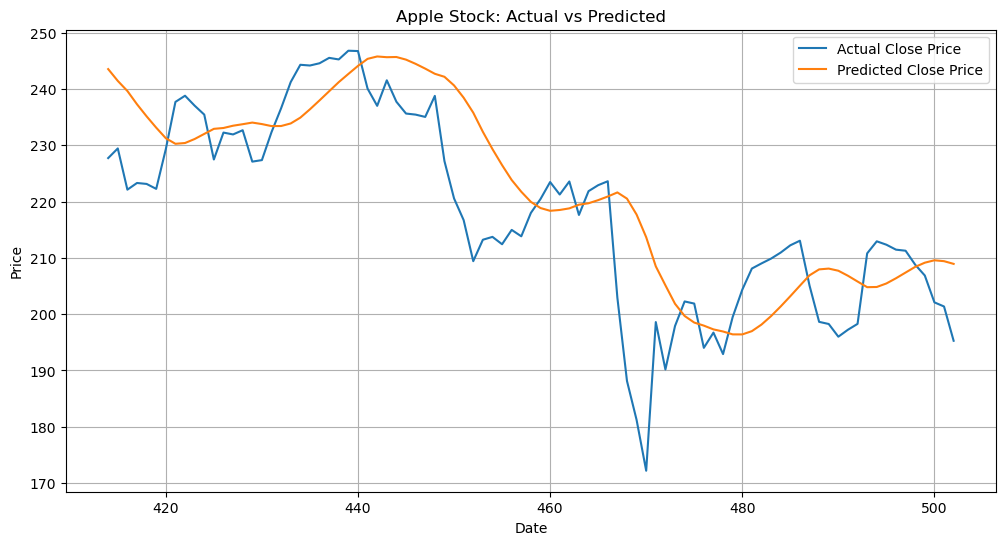

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices, label='Actual Close Price')
plt.plot(test_dates, predicted_prices, label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple Stock: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
model.save('lstm_stock_model.h5')
